In [81]:
import numpy as np
from scipy.stats import beta as beta_dist

# Import base classes instead of defining custom classes
from base_classes.setting import Setting
from base_classes.environment import Environment
from base_classes.specialized_sellers.clairvoyant_oracle_seller import ClairvoyantOracleSeller
from base_classes.specialized_sellers.combinatorial_ucb_seller import CombinatorialUCBSeller
from base_classes.specialized_sellers.primal_dual_seller import PrimalDualSeller

In [82]:
import numpy as np
import matplotlib.pyplot as plt

def run_agents_on_trendflip_env_with_oracle(
    arm_values, T, B,
    # Environment params
    u=0.015, K=25, mu0=0.2, v_target=0.02, mu_bounds=(0.05,0.95), start_dir=+1,
    seed=None,
    # PD hyperparams
    exp3p_eta=None, exp3p_gamma=None, exp3p_dual_lr=None, alpha=None
):
    # Calculate epsilon from arm_values to generate the correct price grid
    if len(arm_values) > 1:
        epsilon = arm_values[1] - arm_values[0]
    else:
        epsilon = 0.1  # fallback
    
    # --- Environment ---
    setting = Setting(
        T=T,
        n_products=1,
        epsilon=epsilon,
        B=B,
        distribution='beta',
        non_stationary='highly',
        trend_flip_params={
            'u': u,
            'K': K,
            'mu0': mu0,
            'v_target': v_target,
            'mu_bounds': mu_bounds,
            'start_dir': start_dir
        },
        verbose='none'  # Disable logging for speed
    )
    
    # --- Agents ---
    ucb = CombinatorialUCBSeller(setting)
    pd = PrimalDualSeller(
        setting,
        eta=exp3p_eta, gamma=exp3p_gamma, alpha=alpha,
        dual_lr=exp3p_dual_lr, rng=seed,
        eta_mult=1.0, forget_beta=0.0,
        use_constant_pacing=True
    )
    orc = ClairvoyantOracleSeller(setting, deterministic=False)
    
    # Set environment reference for clairvoyant oracle
    orc.params = setting.dist_params
    orc._solve_lp_plan()

    # Extract price grid and parameters (price_grid is in seller, not setting)
    prices = ucb.price_grid[0]  # First product's prices from any seller
    a_matrix, b_matrix = setting.dist_params
    
    # --- Tracking ---
    R_ucb = R_pd = R_orc = 0.0
    dep_ucb = dep_pd = dep_orc = None
    cum_ucb, cum_pd, cum_orc = [], [], []

    # --- Fast Direct Simulation (like original notebook) ---
    for t in range(T):
        # Generate valuation for this round
        a_t = a_matrix[t, 0]
        b_t = b_matrix[t, 0]
        v = np.random.beta(a_t, b_t)
        
        # UCB Agent
        if ucb.remaining_budget > 0:
            arm_ucb = ucb.pull_arm()[0]  # Get arm index
            price_ucb = prices[arm_ucb]
            reward_ucb = price_ucb if v >= price_ucb else 0.0
            if reward_ucb > 0:
                ucb.remaining_budget -= 1
            # Update UCB (simplified)
            ucb.history_rewards.append([reward_ucb])
            ucb.history_chosen_prices.append([price_ucb])
            if hasattr(ucb, 'counts'):
                ucb.counts[0, arm_ucb] += 1  # Update count for product 0
                if reward_ucb > 0:
                    if hasattr(ucb, 'successes'):
                        ucb.successes[0, arm_ucb] += 1
            R_ucb += reward_ucb
            if ucb.remaining_budget <= 0 and dep_ucb is None:
                dep_ucb = t + 1
        cum_ucb.append(R_ucb)

        # Primal-Dual Agent
        if pd.remaining_budget > 0:
            arm_pd = pd.pull_arm()[0]  # Get arm index
            price_pd = prices[arm_pd]
            reward_pd = price_pd if v >= price_pd else 0.0
            if reward_pd > 0:
                pd.remaining_budget -= 1
            # Update PD
            pd.update([1 if reward_pd > 0 else 0], [arm_pd])
            R_pd += reward_pd
            if pd.remaining_budget <= 0 and dep_pd is None:
                dep_pd = t + 1
        cum_pd.append(R_pd)

        # Clairvoyant Oracle
        if orc.remaining_budget > 0:
            arm_orc = orc.pull_arm()[0]  # Get arm index
            price_orc = prices[arm_orc]
            reward_orc = price_orc if v >= price_orc else 0.0
            if reward_orc > 0:
                orc.remaining_budget -= 1
            R_orc += reward_orc
            if orc.remaining_budget <= 0 and dep_orc is None:
                dep_orc = t + 1
        cum_orc.append(R_orc)

        # Update round counters appropriately
        ucb.total_steps += 1
        pd.total_steps += 1
        if hasattr(orc, 'current_round'):
            orc.current_round += 1
        elif hasattr(orc, 'total_steps'):
            orc.total_steps += 1

    # --- Diagnostics / labels ---
    ratio_ucb = (R_ucb / R_orc) if R_orc > 0 else np.nan
    ratio_pd  = (R_pd  / R_orc) if R_orc > 0 else np.nan

    lbl_ucb = (
        f"UCB | Total={R_ucb:.2f} | "
        f"{'Depleted@'+str(dep_ucb) if dep_ucb else 'Budget left='+str(ucb.remaining_budget)} | "
        f"UCB/Oracle={ratio_ucb:.2f}"
    )
    lbl_pd = (
        f"Primal–Dual | Total={R_pd:.2f} | "
        f"{'Depleted@'+str(dep_pd) if dep_pd else 'Budget left='+str(pd.remaining_budget)} | "
        f"PD/Oracle={ratio_pd:.2f}"
    )
    lbl_orc = (
        f"Clairvoyant | Total={R_orc:.2f} | "
        f"{'Depleted@'+str(dep_orc) if dep_orc else 'Budget left='+str(orc.remaining_budget)}"
    )

    # --- Plot ---
    plt.figure(figsize=(11, 6))
    rounds = np.arange(1, len(cum_orc) + 1)

    plt.plot(rounds, cum_orc, lw=2.5, label=lbl_orc)
    plt.plot(rounds, cum_ucb, lw=2,   label=lbl_ucb)
    plt.plot(rounds, cum_pd,  lw=2,   label=lbl_pd)

    # mark trend flips
    for tflip in range(K, T, K):
        plt.axvline(tflip, ls='--', color='k', alpha=0.25)

    plt.xlabel("Round")
    plt.ylabel("Cumulative reward")
    plt.title(f"Cumulative Reward — UCB vs Primal–Dual vs Clairvoyant  (T={T}, B={B})")
    plt.legend(fontsize=9)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- Console summary ---
    print("=== Final Results (TrendFlip env, with Oracle) ===")
    print(lbl_orc)
    print(lbl_ucb)
    print(lbl_pd)

    return {
        "cum_ucb": np.array(cum_ucb),
        "cum_pd":  np.array(cum_pd),
        "cum_orc": np.array(cum_orc),
        "R_ucb": R_ucb, "R_pd": R_pd, "R_orc": R_orc,
        "dep_ucb": dep_ucb, "dep_pd": dep_pd, "dep_orc": dep_orc,
        "ratio_ucb": ratio_ucb, "ratio_pd": ratio_pd,
    }

In [83]:
import numpy as np
import matplotlib.pyplot as plt

def plot_trendflip_values(
    T,
    u=0.02,
    K=25,
    mu0=0.2,
    v_target=0.02,
    mu_bounds=(0.05, 0.95),
    start_dir=+1,
    seed=None
):
    """
    Generate and plot valuation samples from Setting with trend-flip.
    
    Args:
      T         : number of rounds
      u         : mean step size per round
      K         : rounds before flipping trend
      mu0       : initial mean
      v_target  : target variance upper bound
      mu_bounds : (min, max) bounds for mean reflection
      start_dir : +1 (ascending) or -1 (descending) starting direction
      seed      : RNG seed
    """
    # Create setting with trend flip
    setting = Setting(
        T=T,
        n_products=1,
        epsilon=0.1,
        B=100,
        distribution='beta',
        non_stationary='highly',
        trend_flip_params={
            'u': u,
            'K': K,
            'mu0': mu0,
            'v_target': v_target,
            'mu_bounds': mu_bounds,
            'start_dir': start_dir
        },
        verbose='none'
    )
    
    # Debug: Check what dist_params looks like
    print(f"Setting dist_params type: {type(setting.dist_params)}")
    print(f"Setting dist_params shape: {np.array(setting.dist_params).shape if hasattr(setting.dist_params, '__len__') else 'scalar'}")
    
    # Extract parameters and generate environment
    if isinstance(setting.dist_params, tuple) and len(setting.dist_params) == 2:
        a_matrix, b_matrix = setting.dist_params
        print(f"a_matrix shape: {a_matrix.shape}, b_matrix shape: {b_matrix.shape}")
        
        # Generate valuations manually to test
        values = []
        mu_path = []
        
        for t in range(T):
            a_t = a_matrix[t, 0]  # First product
            b_t = b_matrix[t, 0]
            mu_t = a_t / (a_t + b_t)  # Beta mean
            mu_path.append(mu_t)
            
            # Sample beta value
            v = np.random.beta(a_t, b_t)
            values.append(v)
    else:
        print("Unexpected dist_params structure")
        return

    rounds = np.arange(1, T+1)

    plt.figure(figsize=(12,5))
    plt.plot(rounds, values, ".", alpha=0.5, label="Sampled valuations")
    plt.plot(rounds, mu_path, "-", color="red", lw=1, label="Mean trajectory")

    # mark trend flips
    for t in range(K, T, K):
        plt.axvline(t, ls="--", color="k", alpha=0.3)

    plt.xlabel("Round")
    plt.ylabel("Valuation")
    plt.title("TrendFlipBetaEnvironment: sampled values and mean trajectory")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

Setting dist_params type: <class 'tuple'>
Setting dist_params shape: (2, 500, 1)
a_matrix shape: (500, 1), b_matrix shape: (500, 1)


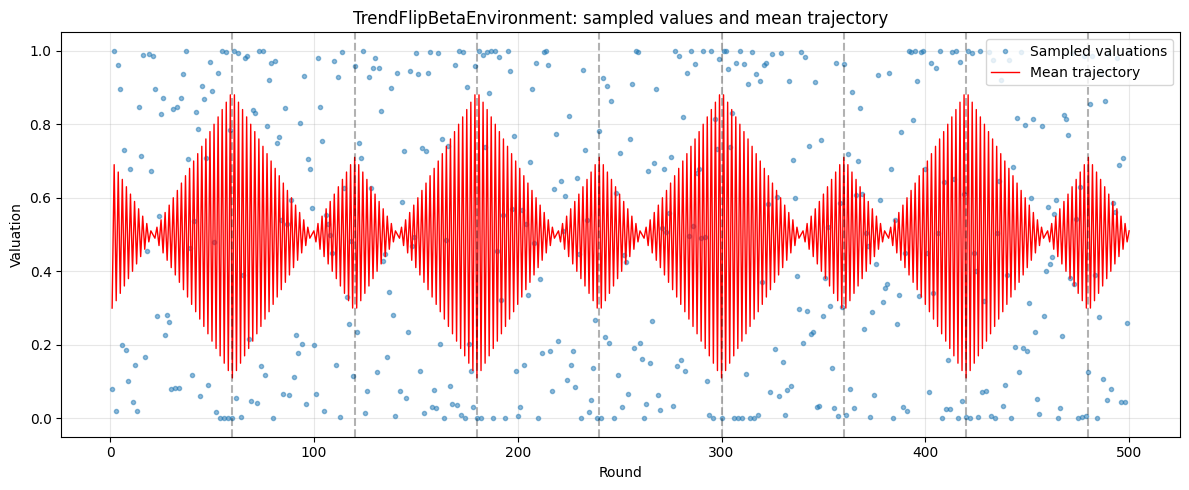

In [84]:
plot_trendflip_values(
    T=500,
    u=0.91,
    K=60,
    mu0=0.3,
    v_target=0.12,
)

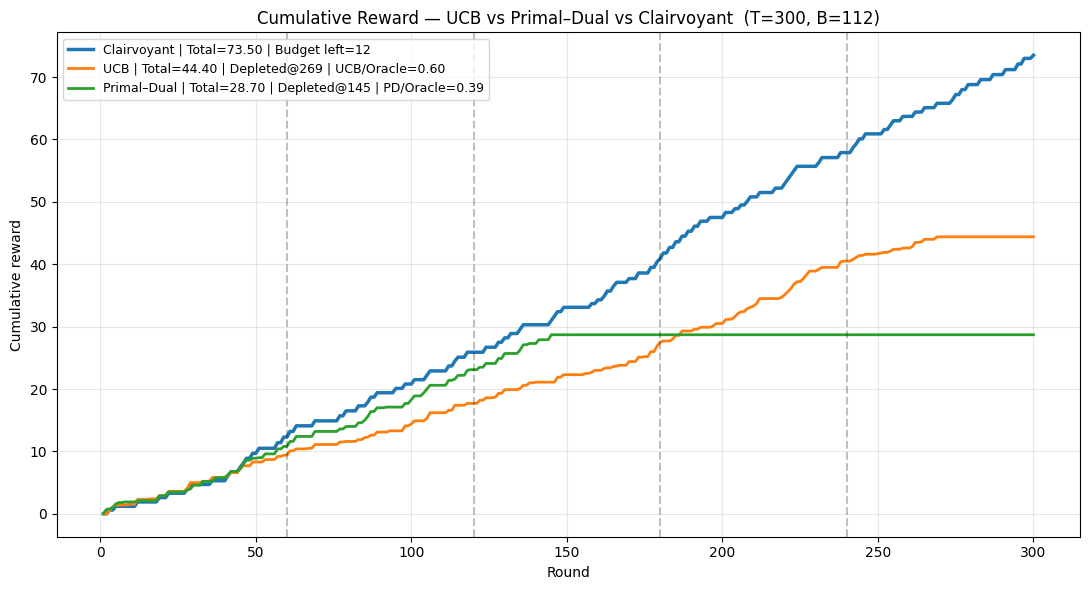

=== Final Results (TrendFlip env, with Oracle) ===
Clairvoyant | Total=73.50 | Budget left=12
UCB | Total=44.40 | Depleted@269 | UCB/Oracle=0.60
Primal–Dual | Total=28.70 | Depleted@145 | PD/Oracle=0.39


In [85]:
res = run_agents_on_trendflip_env_with_oracle(
    arm_values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    T=300,  # Test with smaller T first
    B=112,  # Proportional budget (300 * 0.375)
    u=0.91,       # mean drift per round
    K=60,         # flip every 60 rounds
    mu0=0.3,
    v_target=0.12,
    # PD params (tune as you like)
    exp3p_gamma=None,
    exp3p_eta=0.2,        # canonical eta (gamma/(3K))
    exp3p_dual_lr=0.01,    # pacing step = eta
    alpha=None
)

Setting dist_params type: <class 'tuple'>
Setting dist_params shape: (2, 300, 1)
a_matrix shape: (300, 1), b_matrix shape: (300, 1)


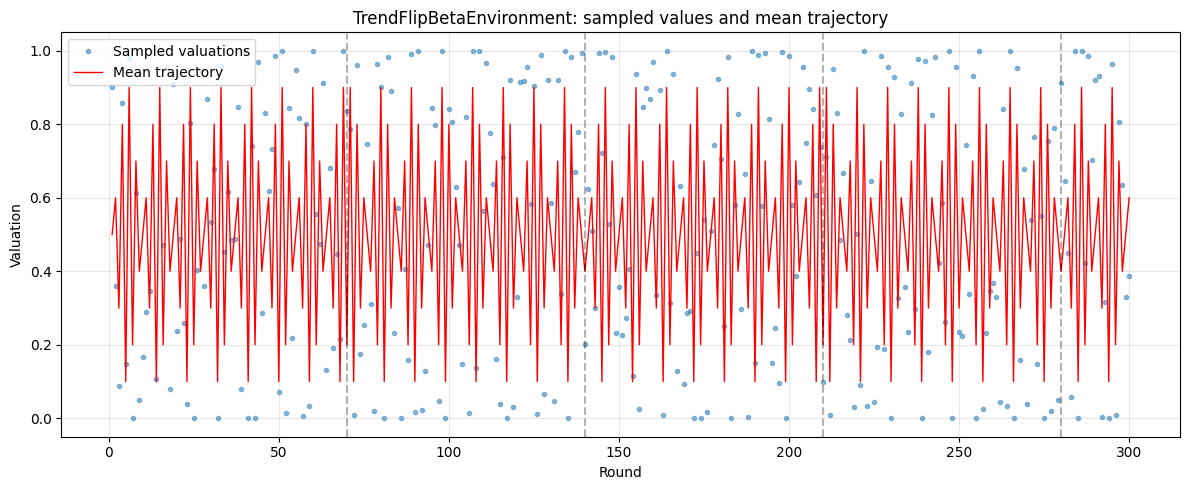

In [86]:
plot_trendflip_values(
    T=300,
    u=0.8,
    K=70,
    mu0=0.5,
    v_target=0.1,
)

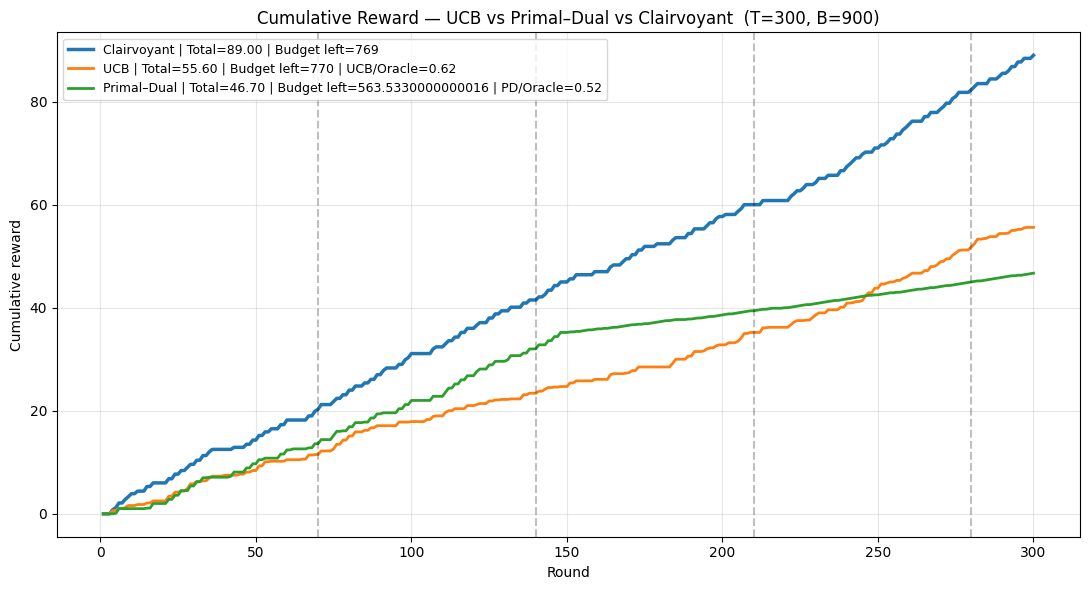

=== Final Results (TrendFlip env, with Oracle) ===
Clairvoyant | Total=89.00 | Budget left=769
UCB | Total=55.60 | Budget left=770 | UCB/Oracle=0.62
Primal–Dual | Total=46.70 | Budget left=563.5330000000016 | PD/Oracle=0.52


In [87]:
res = run_agents_on_trendflip_env_with_oracle(
    arm_values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    T=300,
    B=900,         # B/T = 0.375
    u=0.8,       # mean drift per round
    K=70,         # flip every 70 rounds
    mu0=0.5,
    v_target=0.11,
    # PD params (tune as you like)
    exp3p_gamma=None,
    exp3p_eta=0.2,        # canonical eta (gamma/(3K))
    exp3p_dual_lr=0.01,    # pacing step = eta
    alpha=None
)

Setting dist_params type: <class 'tuple'>
Setting dist_params shape: (2, 1200, 1)
a_matrix shape: (1200, 1), b_matrix shape: (1200, 1)


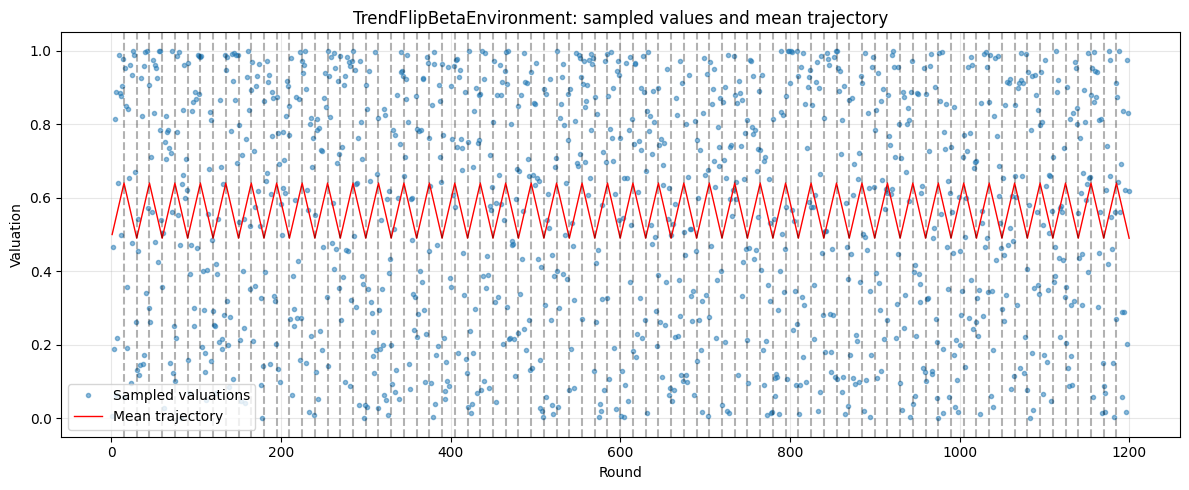

In [88]:
plot_trendflip_values(
    T=1200,
    u=0.01,
    K=15,
    mu0=0.5,
    v_target=0.1,
)

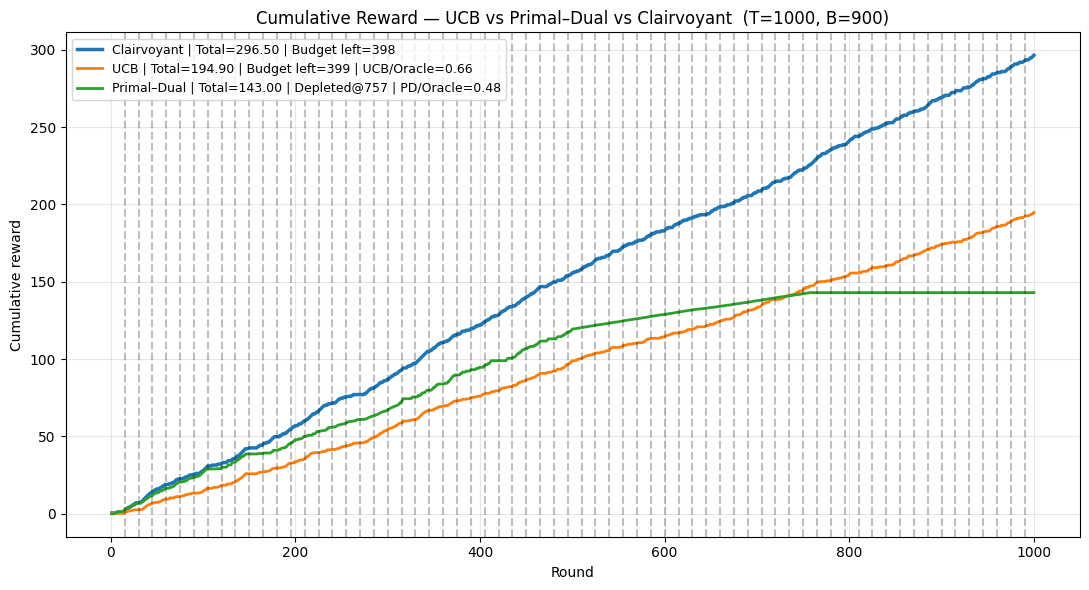

=== Final Results (TrendFlip env, with Oracle) ===
Clairvoyant | Total=296.50 | Budget left=398
UCB | Total=194.90 | Budget left=399 | UCB/Oracle=0.66
Primal–Dual | Total=143.00 | Depleted@757 | PD/Oracle=0.48


In [89]:
res = run_agents_on_trendflip_env_with_oracle(
    arm_values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    T=1000,
    B=900,         # B/T = 0.375
    u=0.01,       # mean drift per round
    K=15,         # flip every 15 rounds
    mu0=0.5,
    v_target=0.1,
    # PD params (tune as you like)
    exp3p_gamma=None,
    exp3p_eta=0.2,        # canonical eta (gamma/(3K))
    exp3p_dual_lr=0.01,    # pacing step = eta
    alpha=None
)

Setting dist_params type: <class 'tuple'>
Setting dist_params shape: (2, 2400, 1)
a_matrix shape: (2400, 1), b_matrix shape: (2400, 1)


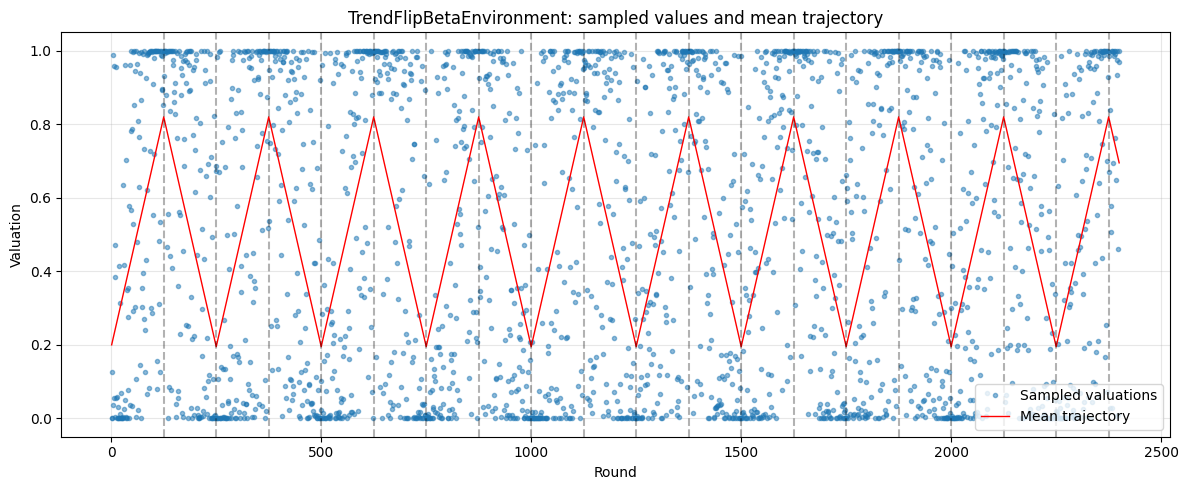

In [90]:
plot_trendflip_values(
    T=2400,
    u=0.005,
    K=125,
    mu0=0.2,
    v_target=0.15,
)

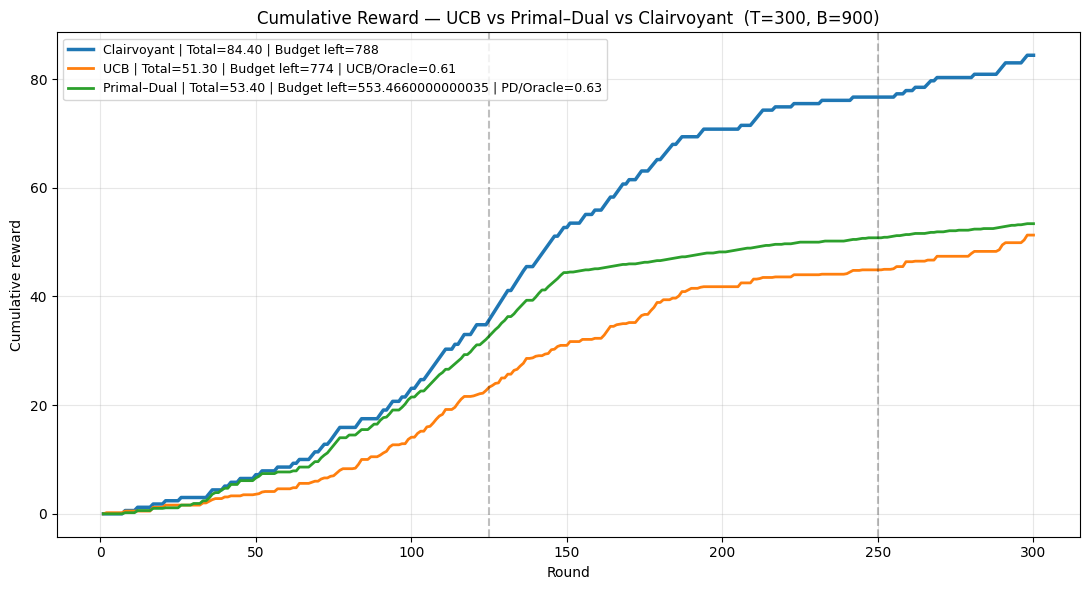

=== Final Results (TrendFlip env, with Oracle) ===
Clairvoyant | Total=84.40 | Budget left=788
UCB | Total=51.30 | Budget left=774 | UCB/Oracle=0.61
Primal–Dual | Total=53.40 | Budget left=553.4660000000035 | PD/Oracle=0.63


In [91]:
res = run_agents_on_trendflip_env_with_oracle(
    arm_values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    T=300,
    B=900,         # B/T = 0.375
    u=0.005,       # mean drift per round
    K=125,         # flip every 125 rounds
    mu0=0.2,
    v_target=0.15,
    # PD params (tune as you like)
    exp3p_gamma=None,
    exp3p_eta=0.2,        # canonical eta (gamma/(3K))
    exp3p_dual_lr=0.01,    # pacing step = eta
    alpha=None
)